In [1]:
%matplotlib inline

from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session =Session(engine)

In [9]:
#sample row for measurement table
session.query(measurement).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x191ede4b640>,
 'prcp': 0.08,
 'id': 1,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397'}

In [10]:
#sample row for station table
session.query(station).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x191ede4bb50>,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'elevation': 3.0,
 'latitude': 21.2716,
 'id': 1}

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
date_sorted = session.query(measurement.date).order_by(measurement.date.desc())
date_sorted.first()[0]


'2017-08-23'

2017-08-23
2016-08-23


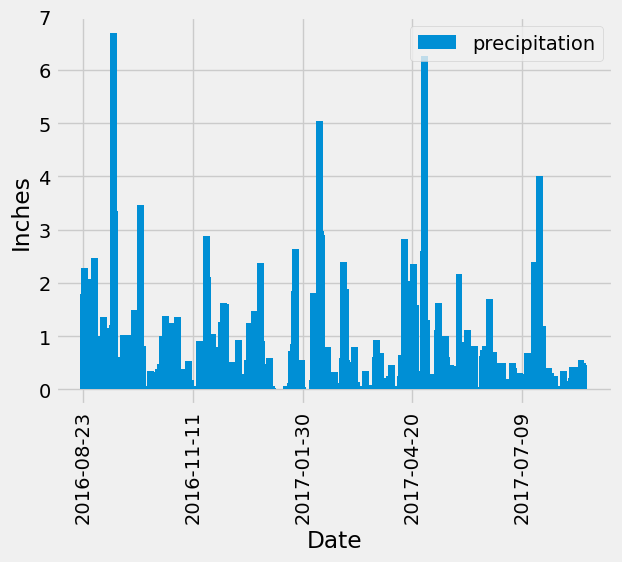

<Figure size 640x480 with 0 Axes>

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
first_date = dt.datetime.strptime(date_sorted.first()[0],'%Y-%m-%d').date()
print(first_date)
# Calculate the date one year from the last date in data set.
t12 = first_date - dt.timedelta(days = 365)
print(t12)
# Perform a query to retrieve the data and precipitation scores
prec_sel = [measurement.date, measurement.prcp]
prec_data = session.query(*prec_sel).\
    filter(measurement.date >= str(t12), measurement.prcp != None).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
prec_db = pd.DataFrame(prec_data, columns=['date', 'precipitation'])
#prec_db.set_index('date', inplace=True)
#prec_db.count()

# Sort the dataframe by date
filter_prec = prec_db[prec_db['precipitation'] != None]
sorted_prec = filter_prec.sort_values('date').groupby('date')

# Take max precipitation per date
max_prec = sorted_prec.max()

# Use Pandas Plotting with Matplotlib to plot the data
prec_bar = max_prec.plot.bar(width = 5)
plt.locator_params(axis= 'x', nbins = 4.6)
plt.ylabel('Inches')
plt.xlabel('Date')
plt.xlim(-20, int(max_prec.count()) + 20)
plt.ylim(-0.3, 7)
plt.show()
plt.tight_layout()




In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
prec_db.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(func.count(station.station)).all()
stations


[(9,)]

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_count = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
[x for x in station_count]

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_sel = [
    func.min(measurement.tobs), 
    func.max(measurement.tobs), 
    func.avg(measurement.tobs)
    ]

active_query = session.query(*active_sel).filter(measurement.station == station_count[0][0])
[x for x in active_query]

[(54.0, 85.0, 71.66378066378067)]

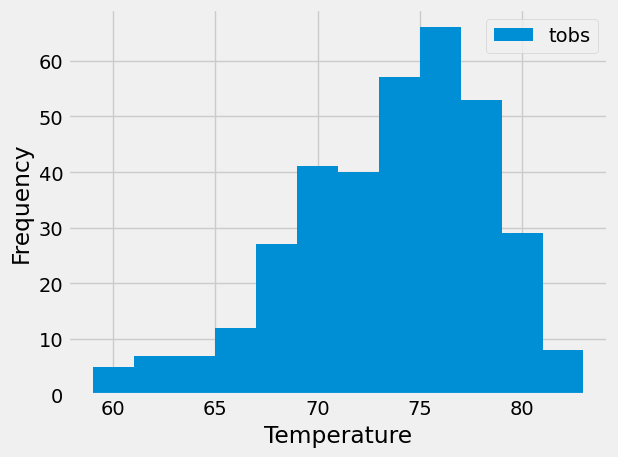

In [24]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#tobs_data = session.query(measurement.tobs, func.count(measurement.tobs)).\
    #filter(measurement.station == station_count[0][0] , measurement.date >= str(t12), measurement.prcp != None).\
        #group_by(measurement.tobs).order_by(measurement.tobs).all()

tobs_data = session.query(measurement.tobs).\
    filter(measurement.station == station_count[0][0] , measurement.date >= str(t12)).\
        order_by(measurement.tobs).all()

values = [row[0] for row in tobs_data]

plt.hist(values, bins = 12)
plt.legend(['tobs'], loc = 'best')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()